In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string
from sklearn.preprocessing import OneHotEncoder

In [5]:
file_path_volts1 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF1V.csv"
file_path_amps1 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H2\Tagged_Training_02_15_1360915201\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF2V.csv"
file_path_amps2 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H2\Tagged_Training_02_15_1360915201\TimeTicks2.csv"

file_path_labels = r".\dataset\H2\AllTaggingInfo.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

labels = pd.read_csv(file_path_labels)

In [6]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [7]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

power = L1_actual_power + L2_actual_power[:len(L1_actual_power)]

In [8]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
TS2_real = np.array(time_ticks2_datetime)

In [9]:
print(TS1_real[0])
print(TS1_real[len(TS1_real) - 1])

print(TS2_real[0])
print(TS2_real[len(TS1_real) - 1])

2013-02-15T08:00:01.179514880
2013-02-16T07:59:58.976457984
2013-02-15T08:00:01.258717952
2013-02-16T07:59:58.607661056


In [10]:
labels["ON_Time"] = pd.to_datetime(labels["ON_Time"], unit='s')
labels["OFF_Time"] = pd.to_datetime(labels["OFF_Time"], unit='s')

In [11]:
labels.head(76)

,ApplianceID,ApplianceName,ON_Time,OFF_Time
0,16,Kitchen Lights,2012-06-13 17:00:00,2012-06-13 17:01:00
1,16,Kitchen Lights,2012-06-13 17:02:00,2012-06-13 17:02:30
2,16,Kitchen Lights,2012-06-13 17:03:30,2012-06-13 17:04:30
3,16,Kitchen Lights,2012-06-13 17:05:30,2012-06-13 17:06:00
4,17,Kitchen Table Lights,2012-06-13 17:06:30,2012-06-13 17:07:00
...,...,...,...,...
71,32,Straightening Iron,2013-02-15 18:11:30,2013-02-15 18:12:00
72,32,Straightening Iron,2013-02-15 18:15:00,2013-02-15 18:15:00
73,13,Garbage Disposal,2013-02-15 18:16:00,2013-02-15 18:16:00
74,13,Garbage Disposal,2013-02-15 18:17:00,2013-02-15 18:17:00


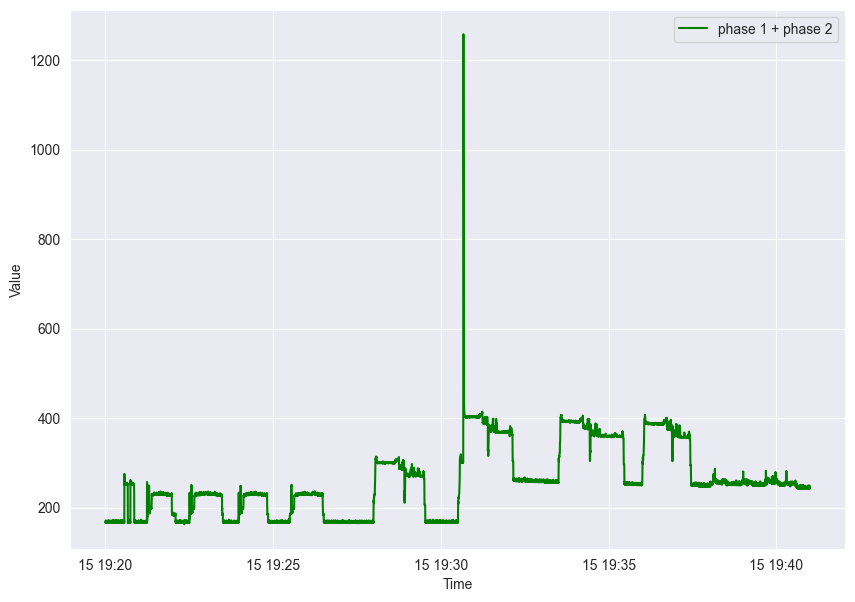

In [12]:
# Example date: 2023-10-10 12:00:00
def zoomIn(start_time: string, end_time: string, time_ticks):
    date_format = "%Y-%m-%d %H:%M:%S"
    # We add two hours because for some reason the start/end index are two hours short
    start_time = (datetime.strptime(start_time, date_format) + timedelta(hours=1)).timestamp()
    end_time = (datetime.strptime(end_time, date_format) + timedelta(hours=1)).timestamp()

    start_index = -1
    end_index = -1
    for index in range(len(TS1_real)):
        if time_ticks[index] > start_time and start_index == -1:
            start_index = index
        if time_ticks[index] > end_time and end_index == -1:
            end_index = index
    return start_index, end_index


start_index, end_index = zoomIn("2013-02-15 19:20:00", "2013-02-15 19:41:00", time_ticks1_np)
plt.figure(figsize=(10, 7))

#This plots total power consumption (zoomed in)
plt.plot(TS2_real[start_index:end_index], power[start_index:end_index], linestyle='-', color='g', label='phase 1 + phase 2')

#This plots total power consumption
# plt.plot(TS1_real, power, linestyle='-', color='g', label='phase 1 + phase 2')

# This plots phase 1 and phase 2 separately (zoomed in)
# plt.plot(TS1_real[start_index:end_index], L1_actual_power[start_index:end_index], linestyle='-', color='b', label='L1')
# plt.plot(TS2_real[start_index:end_index], L2_actual_power[start_index:end_index], linestyle='-', color='r', label='L2')

# This plots phase 1 and phase 2 separately (whole thing)
# plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
# plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def moving_average(window: int, threshold: int, power):
    df = pd.DataFrame(power)
    df = df.rolling(window=window).mean()
    return df.to_numpy()

test = moving_average(20, power)
plt.figure(figsize=(10, 7))
plt.plot(TS1_real, test, linestyle='-', color='g', label='phase 1 + phase 2')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

TypeError: moving_average() missing 1 required positional argument: 'power'

In [22]:
def encode(label, total_labels):
    array = np.zeros(total_labels + 1)
    array[label] = 1
    return array

def process_data(power, time_ticks, labels, window):
    data = []
    appliances = []
    time = []

    for index in range(len(power) - window + 1):
        window_start = index
        window_end = index + window
        data.append(power[window_start:window_end])
        time.append(time_ticks[window_start:window_end])

        found = False
        for label in labels.iterrows():
            label = label[1]
            start_time = datetime.utcfromtimestamp(time_ticks[window_start].item())
            end_time = datetime.utcfromtimestamp(time_ticks[window_end].item())

            if label["ON_Time"] <= start_time <= label["OFF_Time"] or label["ON_Time"] <= end_time <= label["OFF_Time"]:
                found = True
                appliances.append(encode(label["ApplianceID"], max(labels["ApplianceID"])))
                break

        if not found:
            appliances.append(encode(0, max(labels["ApplianceID"])))

    data = np.array(data)
    time = np.array(time)
    appliances = np.array(appliances)
    # TODO: SHUFFLE DATA

    return data, time, appliances

data, time, appliances = process_data(power, time_ticks1_np, labels, 10)

KeyboardInterrupt: 